### WARC Text Mining Simulation

1. WARC 파일 생성(Python WARCIO 라이브러리 활용)
2. 형태소 처리(명사 및 용언 추출)
3. 동시출현(Collocation) 단어 네트워크 분석

##### 1. WARC 파일 생성

청와대(https://www.president.go.kr/) 메인페이지를 WARCIO 라이브러리를 통해 수집하여 WARC 포멧에 맞는 압축 파일로 저장한다.

In [76]:
from warcio.warcwriter import WARCWriter
from warcio.statusandheaders import StatusAndHeaders

import requests

# 저장 파일명: president.warc.gz
with open('president.warc.gz', 'wb') as output:
    writer = WARCWriter(output, gzip=True)

    resp = requests.get('https://www.president.go.kr/',
                        headers={'Accept-Encoding': 'identity'},
                        stream=True)

    # get raw headers from urllib3
    headers_list = resp.raw.headers.items()

    http_headers = StatusAndHeaders('200 OK', headers_list, protocol='HTTP/1.0')

    record = writer.create_warc_record('https://www.president.go.kr/', 'response',
                                        payload=resp.raw,
                                        http_headers=http_headers)

    writer.write_record(record)

생성된 파일이 WARC 포멧에 맞는지 다른 범용 WARC 처리 라이브러리를 통해 점검한다.

In [81]:
import warcat.model
warc = warcat.model.WARC()
warc.load('president.warc.gz')

record = warc.records[0]
print("warc record type: ", record.warc_type)
print("warc record header version: ", record.header.version)
print("warc record header fields list: ", record.header.fields.list())
print("warc record content_block fields list(): ", record.content_block.fields.list())



warc record type:  response
warc record header version:  1.0
warc record header fields list:  [('WARC-Type', 'response'), ('WARC-Record-ID', '<urn:uuid:5ead31bc-33c1-416f-844d-bf44af48ec9e>'), ('WARC-Target-URI', 'https://www.president.go.kr/'), ('WARC-Date', '2022-08-18T13:39:34Z'), ('WARC-Payload-Digest', 'sha1:6AWRQG6ER266CUZMLNUQNVOCE2JH26YJ'), ('WARC-Block-Digest', 'sha1:QATIBHOMP3ZH2QXKCYDR43AFK5JAGFBG'), ('Content-Type', 'application/http; msgtype=response'), ('Content-Length', '32741')]
warc record content_block fields list():  [('Date', 'Thu, 18 Aug 2022 13:39:35 GMT'), ('Content-Type', 'text/html; charset=UTF-8'), ('Transfer-Encoding', 'chunked'), ('Connection', 'keep-alive'), ('Set-Cookie', 'PHPSESSID=vj46gkushdtdpl25kuedfu1jj7; path=/'), ('Expires', 'Thu, 19 Nov 1981 08:52:00 GMT'), ('Cache-Control', 'no-store, no-cache, must-revalidate, post-check=0, pre-check=0'), ('Pragma', 'no-cache'), ('Via', '1.1 PShgseSEL5yi123:14 (W), 1.1 PSrbdbOSA1rw96:5 (W)'), ('X-Px', 'ms PSrbdbO

##### 2. 형태소 처리(명사 및 용언)
WARC 파일을 로딩하여 텍스트마이닝을 위한 전처리 작업을 한다.

##### 2.1 WARC 파일 읽고 HTML 파일로 저장하기
일단 HTML 형태로 읽는 기능을 테스트한다.

In [82]:
# warcio streaming

import requests
from warcio.archiveiterator import ArchiveIterator

with open('president.warc.gz', 'rb') as stream:
    for record in ArchiveIterator(stream):
        if record.rec_type == 'response':
                print(record.content_stream().read().decode())

<!DOCTYPE html>
<html lang="ko">
<head>
<meta charset="utf-8"/>

<meta name="viewport" content="width=device-width, initial-scale=1, minimum-scale=1, maximum-scale=2, user-scalable=yes, viewport-fit=cover"/>
<title>제20대 대통령실</title>
<meta name="keyword" content="대한민국대통령, 윤석열, 윤석열 당선인, 윤석열 대통령, 제20대 대통령, 대통령실, 청와대, 국민속으로 용산시대, 국민의 대통령, 윤대통령, 제20대 대통령 윤석열"/>
<meta name="description" content="다시 대한민국 새로운 국민의 나라"/>
<meta property="og:title" content="대한민국 제20대 대통령 윤석열"/>
<meta property="og:url" content="https://www.president.go.kr/index.php"/>
<meta property="og:type" content="website"/>
<meta property="og:image" content="https://www.president.go.kr/thumb_img_new.jpg"/>
<meta property="og:site_name" content="대한민국 제20대 대통령 윤석열"/>
<meta property="og:description" content="다시 대한민국 새로운 국민의 나라"/>
<meta name="naver-site-verification" content="f160274b37f75d8d40b6e2580c4c30e6001d8f49" />
<link rel="canonical" href="https://www.president.go.kr/"/>
<link rel="shortcut icon" href="https://www.presiden

복원된 HTML 콘텐츠를 파일로 저장한다. (이후 텍스트만 추출하기 위함)

In [83]:
# warcio streaming
from contextlib import redirect_stdout
import requests
from warcio.archiveiterator import ArchiveIterator

with open('president.warc.gz', 'rb') as stream:
    for record in ArchiveIterator(stream):
        if record.rec_type == 'response':
                with open('president_warc_to.html', 'w', encoding='UTF-8', ) as filedata:
                    with redirect_stdout(filedata):
                        print(record.content_stream().read().decode())

HTML 파일에서 태그를 제거한다. 랜덤한 위치를 선택해서 제거가 잘 되었는지 미리보기를 한다.

In [90]:
import re

CLEANR = re.compile('<.*?>') 

def cleanhtml(raw_html):
  cleantext = re.sub(CLEANR, '', raw_html)
  return cleantext

with open('writehtml.html', 'r', encoding='UTF-8') as file:
    data = file.read().replace('\n', '')
    data = cleanhtml(data)

# 랜덤한 위치 프리뷰
data[1000:2000]

'ow.location = "https:" + restOfUrl;\t}\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t \t\t\t\t\t\t\t\t\t\tAUTO\t\t\t\t\t\t\t\t\t오직 국민만 믿고, 오직 국민의 뜻을 따르겠습니다.\t\t\t윤석열 정부의 국정과제\t\t\t\t\t\t\t\t\t\t\t\t\t국민에게 알립니다\t\t\t\t더보기\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t\t제77주년 광복절 경축사\t\t\t\t\t\t존경하고 사랑하는 국민 여러분,750만 재외동포 여러분&nbsp;오늘은 제77주년 광복절입니다.&nbsp;조국의 독립을 위해 희생하고 헌신하신 순국선열과 애국지사들, 그리고 유가족 여러분께 깊은 감사와 경의를 표합니다.&nbsp;&nbsp;일제 강점기 시절 독립운동은 3.1 독립선언과 상해 임시정부 헌장, 그리고 매헌 윤봉길 선생의 독립 정신에서 보는 바와 같이 국민이 주인인 민주공화국, 자유와 인권, 법치가 존중되는 나라를 세우기 위한 것이었습니다.&nbsp;자유와 인권이 무시되는 전체주의 국가를 세우기 위한 독립운동은 결코 아니었습니다. 일제 강점기 시절 순국선열과 애국지사를 비롯하여 모든 국민이 함께 힘써온 독립운동은 1945년 바로 오늘, 광복의 결실을 이뤄냈습니다.&nbsp;&nbsp;그러나 독립운동은 거기서 끝난 것이 아닙니다. 그 이후 공산 세력에 맞서 자유국가를 건국하는 과정, 자유민주주의의 토대인 경제성장과 산업화를 이루는 과정, 그리고 이를 바탕으로 민주주의를 발전시켜온 과정을 통해 계속되어왔고 현재도 진행 중인 것입니다.&nbsp;&nbsp;과거에는 약소국이 강대국에 의해 억압되고 박탈된 국민의 자유를 되찾기 위해 주권 국가를 세우는 것이 시대적 사명이었습니다.&nbsp;&nbsp;앞으로의 시대적 사명은 보편적 가치를 공유한 국가들이 연대하여 자유와 인권에 대한 위협에 함께 대항하고 세계시민의 자유와 평화, 그리고 번영을 이뤄내는 것입니다.&nbsp;자유를 찾기 위

태그는 제거되었으나 많은 URL정보, 개행문자, 탭문자들이 포함되어 있다. 

다음에서 명사, 용언(동사, 형용사)등 형태소만 추출할 것이기 때문에 추가 정제작업은 할 필요가 없다. 

KoNLPy의 Kkma 형태소 태깅을 사용한다.

In [91]:
# Kkma 활용
from konlpy.tag import Kkma
kkma = Kkma()

# 명사 동사 추출 함수
def NounAndVerb(text):
    text_str = str(text)
    morph_list = kkma.pos(text_str)
    
    # Okt
    #result = list(filter(lambda x: x[1] == "Noun" or x[1] == "Verb", morph_list))
    
    # Kkma 태그: NNG 일반명사, NNP 고유명사, VV 동사, VA 형용사
    # 
    result = list(filter(lambda x: x[1] == "NNG" or x[1] == "NNP" or x[1] == "VV" or x[1] == "VA", morph_list))
    morphed_txt=""
    for item in result:
        if len(item[0])==1:
            continue
        elif item[1] == "VV" or item[1] == "VA" or item[1] == "VV":
            morphed_txt += " " + item[0] +"다"
        else:
            morphed_txt += " " + item[0]

    return(morphed_txt)


In [92]:
NounsAndVerbs = NounAndVerb(data)
NounsAndVerbs

' 대통령 이동 메뉴 본문 대통령 글자 크기 국민 대통령 대통령 공개 일정 대통령 말과 국민 집무실 시대 조직도 청와대 국민 국정 과제 국정 비전 국정 목표 국정 과제 정부 업무 보고 정책 브리핑 국민 국민 제안 국민 알리다 브리핑 카드 뉴스 역대 대통령 기록 오시다 정보 공개 제도 안내 처리 절차 법령 서식 사전 정보 공표 목록 수수료 안내 정보 공개 청구 정보 자료실 이동 국민 국민 따르다 정부 국정 과제 국민 알리다 보기 광복절 경축 존경 사랑 국민 재외 동포 오늘 광복절 조국 독립 위하다 희생 신하신 순국 선열 애국 지사 가족 감사 경의 표하다 일제 강점기 시절 독립운동 독립 선언 상해 임시 정부 헌장 윤봉길 선생 독립 정신 국민 주인 민주 공화국 자유 인권 법치 존중 나라 세우다 위하다 자유 인권 무시 전체주의 국가 세우다 위하다 독립운동 아니다 일제 강점기 시절 순국 선열 애국 지사 국민 힘쓰다 독립운동 오늘 광복 결실 이루다 독립 운동 끝나다 아니다 이후 공산 세력 자유 국가 건국 과정 자유 민주주의 토대 경제 성장 산업화 이루다 과정 바탕 민주주의 발전 과정 통하다 계속 현재 진행 과거 약소국 강대국 의하다 억압 박탈 국민 자유 되찾다 위하다 주권 국가 세우다 시대적 사명 시대적 사명 보편적 가치 공유 국가 연대 자유 인권 대하다 위협 대항 세계 시민 자유 평화 번영 이루다 자유 위하다 시작 독립운동 진정하다 자유 기초 경제적 토대 제도적 민주주의 구축 이어지다 이제 보편적 가치 기반 세계 시민 자유 지키다 확대 계승 발전 존경 국민 광복절 오늘 과거 미래 관통 독립운동 세계사 의미 새기다 역사적 시기 독립 운동 성격 시대적 사명 달리하다 진행 역동적 과정 자유 자유 지키다 자유 확대 세계 시민 연대 자유 대하다 위협 싸우다 세계 평화 번영 이루다 조국 미래 보이다 캄캄하다 일제 강점기 자신 목숨 초개 버리다 국내외 무장 투쟁 전개 실천 무장 독립 운동가 기르다 내신 생각 지금 가슴 벅차오르다 자유 민주주의 국가 건설 민족 역량 키우다 위하다 국

##### 3. 동시출현(Collocation) 단어 네트워크 분석

In [45]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import nltk
from nltk import bigrams
from nltk.corpus import stopwords
import re
import networkx as nx

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

위에서 생성한 단어들을 리스트로 전환한다.

In [ ]:
tokens = nltk.word_tokenize(NounsAndVerbs)

NLTK의 Bigram 모듈을 사용하여, 동시에 출현하는 두 단어 세트를 추출한다.

In [93]:
terms_bigram = list(nltk.bigrams(tokens))
terms_bigram 

bigrams = list(itertools.chain(terms_bigram))
bigrams

bigram_counts = collections.Counter(bigrams)

bigram_df = pd.DataFrame(bigram_counts.most_common(20),
                             columns=['bigram', 'count'])

bigram_df

,bigram,count
0,"(애국, 지사)",9
1,"(한국, 광복군)",7
2,"(보편적, 가치)",6
3,"(광복군, 선열)",6
4,"(독립, 위하다)",5
5,"(일제, 강점기)",5
6,"(자유, 인권)",5
7,"(세계, 시민)",5
8,"(자유, 지키다)",5
9,"(선열, 합동)",5


생성된 동시출현 단어세트를 네트워크 그래프 데이터구조로 변경한다.

In [94]:
d = bigram_df.set_index('bigram').T.to_dict('records')
# Create network plot 
G = nx.Graph()

# Create connections between nodes
for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))


네트워크 그래프로 구조화된 동시출현(collocation) 단어세트를 네트워크 다이어그램으로 시각화한다.

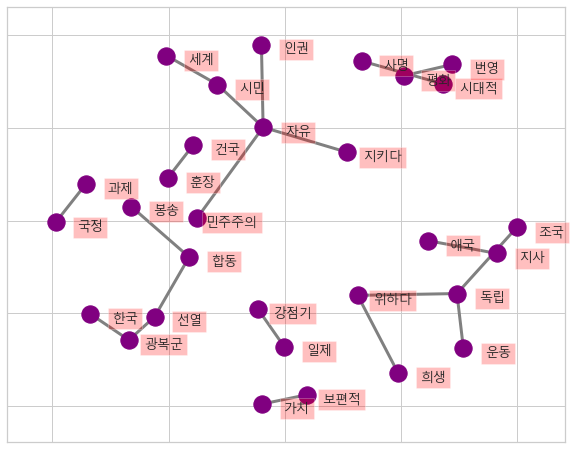

In [119]:
import matplotlib.font_manager as fm 
from matplotlib import rc
font_name = fm.FontProperties(fname='C:\Windows\Fonts\malgun.ttf').get_name()
rc('font', family=font_name)

fig, ax = plt.subplots(figsize=(10, 8))

pos = nx.spring_layout(G, k=2.2)

# Plot networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=3,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax, font_family=font_name)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.15, value[1]-.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

크게 두가지 네트워크를 찾을 수 있다.
1. "자유" 키워드를 중심으로 노드가 펼쳐지는 네트워크: 자유와 함께 인권, 민주주의 등이 동시에 사용되었다.
2. "독립" 키워드를 중심으로 노드가 펼쳐지는 네트워크: 운동, 위하다 등의 단어가 동시에 사용되었다.